In [1]:
import os
import importlib.util

# Define the path to config.py
config_path = os.path.abspath(os.path.join(os.path.dirname(r'C:\Users\nilay\OneDrive - Cal State Fullerton (1)\Desktop\NILAY-TO-JOB-DATA\SPRING 2024\CPSC 597 Project\Stock-Price-Prediction'), 'Stock-Price-Prediction', 'config.py'))

# Load the module from the specified path
spec = importlib.util.spec_from_file_location("config", config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [29]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

file_path = os.path.join(config.BASE_DIR, 'dataset', 'preprocessed_data', 'AAPL.csv')
df = pd.read_csv(file_path)
df = df[['Date', 'Open', 'High', 'Low', 'Close']]

# Convert date from string to datetime
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')
df.dropna(axis=0, inplace=True)

# Initialize scalers for each column
scalers = {
    'Open': MinMaxScaler(),
    'High': MinMaxScaler(),
    'Low': MinMaxScaler(),
    'Close': MinMaxScaler()
}

# Scale each column separately
for column in ['Open', 'High', 'Low', 'Close']:
    df[column] = scalers[column].fit_transform(df[[column]])


In [30]:
import pandas as pd
import numpy as np
import datetime

# Redefine str_to_datetime function to handle different date formats if needed
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Function to create a windowed dataframe
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X_open, X_high, X_low, X_close, Y_open, Y_high, Y_low, Y_close = [], [], [], [], [], [], [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        open_values = df_subset['Open'].to_numpy()
        high_values = df_subset['High'].to_numpy()
        low_values = df_subset['Low'].to_numpy()
        close_values = df_subset['Close'].to_numpy()

        X_open.append(open_values[:-1])
        Y_open.append(open_values[-1])
        
        X_high.append(high_values[:-1])
        Y_high.append(high_values[-1])
        
        X_low.append(low_values[:-1])
        Y_low.append(low_values[-1])
        
        X_close.append(close_values[:-1])
        Y_close.append(close_values[-1])

        dates.append(target_date)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    data = {
        'Target Date': dates
    }

    X_open = np.array(X_open)
    X_high = np.array(X_high)
    X_low = np.array(X_low)
    X_close = np.array(X_close)

    for i in range(n):
        data[f'Open-{n-i}'] = X_open[:, i]
        data[f'High-{n-i}'] = X_high[:, i]
        data[f'Low-{n-i}'] = X_low[:, i]
        data[f'Close-{n-i}'] = X_close[:, i]

    data['Open-Target'] = Y_open
    data['High-Target'] = Y_high
    data['Low-Target'] = Y_low
    data['Close-Target'] = Y_close

    ret_df = pd.concat({key: pd.Series(value) for key, value in data.items()}, axis=1)

    return ret_df

# Start day second time around: 1990-01-02 -- 2006-12-29
windowed_df = df_to_windowed_df(df, 
                                '2016-06-10', 
                                '2024-06-27',
                                n=50)
windowed_df


,Target Date,Open-50,High-50,Low-50,Close-50,Open-49,High-49,Low-49,Close-49,Open-48,...,Low-2,Close-2,Open-1,High-1,Low-1,Close-1,Open-Target,High-Target,Low-Target,Close-Target
0,2016-06-10,0.125863,0.124575,0.127592,0.125558,0.124783,0.124689,0.126794,0.126712,0.126668,...,0.115618,0.113959,0.112969,0.113322,0.115359,0.114778,0.113004,0.112595,0.115383,0.113832
1,2016-06-13,0.124783,0.124689,0.126794,0.126712,0.126668,0.127176,0.129224,0.128016,0.125622,...,0.115359,0.114778,0.113004,0.112595,0.115383,0.113832,0.113187,0.112334,0.113763,0.112112
2,2016-06-14,0.126668,0.127176,0.129224,0.128016,0.125622,0.125518,0.128226,0.126504,0.126449,...,0.115383,0.113832,0.113187,0.112334,0.113763,0.112112,0.111613,0.111607,0.113352,0.112251
3,2016-06-15,0.125622,0.125518,0.128226,0.126504,0.126449,0.125802,0.127968,0.127831,0.126128,...,0.113763,0.112112,0.111613,0.111607,0.113352,0.112251,0.112188,0.111528,0.113681,0.111882
4,2016-06-16,0.126449,0.125802,0.127968,0.127831,0.126128,0.125166,0.126700,0.125038,0.124932,...,0.113352,0.112251,0.112188,0.111528,0.113681,0.111882,0.110613,0.110778,0.112554,0.112355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,2024-06-21,0.775720,0.767840,0.784504,0.774306,0.773605,0.796775,0.789435,0.807821,0.800819,...,1.000000,0.989013,0.983176,0.972928,0.980512,0.967732,0.966903,0.962253,0.972341,0.957622
2021,2024-06-24,0.773605,0.796775,0.789435,0.807821,0.800819,0.809948,0.817845,0.814792,0.805875,...,0.980512,0.967732,0.966903,0.962253,0.972341,0.957622,0.954629,0.965932,0.969899,0.960622
2022,2024-06-25,0.800819,0.809948,0.817845,0.814792,0.805875,0.802090,0.809815,0.796973,0.789280,...,0.972341,0.957622,0.954629,0.965932,0.969899,0.960622,0.961203,0.959937,0.979385,0.964916
2023,2024-06-26,0.805875,0.802090,0.809815,0.796973,0.789280,0.789053,0.789952,0.781692,0.779443,...,0.969899,0.960622,0.961203,0.959937,0.979385,0.964916,0.972005,0.975744,0.988918,0.984212


In [17]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    # Extract the features (Open, High, Low, Close) from the columns
    middle_matrix = df_as_np[:, 1:-4]
    # Reshape the features matrix to include the multiple feature sets
    # Each row has n Open, High, Low, and Close values
    num_features = 4  # We have Open, High, Low, Close
    n = (middle_matrix.shape[1] // num_features)  # Number of time steps (n=3 in this case)
    X = middle_matrix.reshape((len(dates), n, num_features))

    # Extract the target values (Open-Target, High-Target, Low-Target, Close-Target)
    Y_open = df_as_np[:, -4]
    Y_high = df_as_np[:, -3]
    Y_low = df_as_np[:, -2]
    Y_close = df_as_np[:, -1]

    # Combine all target values into a single array
    Y = np.stack((Y_open, Y_high, Y_low, Y_close), axis=-1)

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2025,), (2025, 50, 4), (2025, 4))

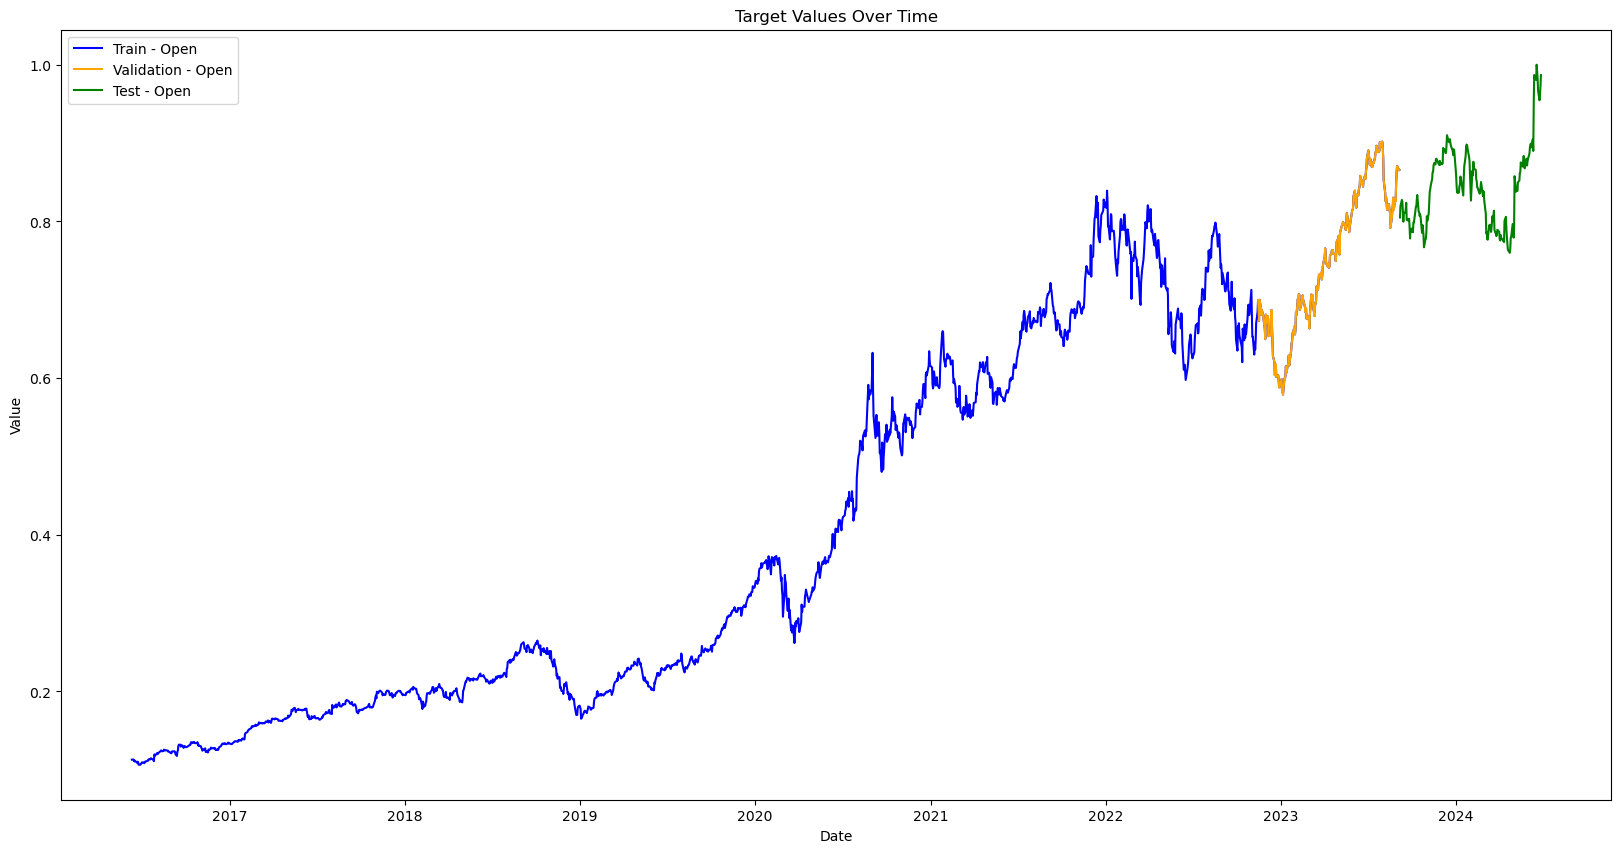

In [18]:
import matplotlib.pyplot as plt

q_80 = int(len(dates) * .80)
q_90 = int(len(dates) * .90)

dates_train2, X_train2, y_train2 = dates[:q_90], X[:q_90], y[:q_90]
dates_val2, X_val2, y_val2 = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test2, X_test2, y_test2 = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(20, 10))

# Plotting target values for each feature set
plt.plot(dates_train2, y_train2[:, 0], label='Train - Open', color='blue')
plt.plot(dates_val2, y_val2[:, 0], label='Validation - Open', color='orange')
plt.plot(dates_test2, y_test2[:, 0], label='Test - Open', color='green')

plt.legend()
plt.title('Target Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model_2 = Sequential([
    layers.Input((3, 4)),
    layers.LSTM(256),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(4)
])

# Compile the model
model_2.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

# Train the model with early stopping
model_2.fit(X_train2, y_train2, 
          validation_data=(X_val2, y_val2), 
          epochs=100, 
          callbacks=[early_stopping])


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - loss: 0.1702 - mean_absolute_error: 0.3375 - val_loss: 0.0132 - val_mean_absolute_error: 0.1079
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - loss: 0.0017 - mean_absolute_error: 0.0302 - val_loss: 0.0013 - val_mean_absolute_error: 0.0314
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 5.6985e-04 - mean_absolute_error: 0.0179 - val_loss: 9.8122e-04 - val_mean_absolute_error: 0.0272
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - loss: 5.4559e-04 - mean_absolute_error: 0.0172 - val_loss: 9.0769e-04 - val_mean_absolute_error: 0.0261
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 5.3784e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0010 - val_mean_absolute_error: 0.0282
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 5.3998e-04 - mean_absolute_error: 0.0166 - val_loss: 8.3694e-04 - val_mean_absolute_error: 0.0249
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 4.

In [31]:
predictions = model_2.predict(X_test2)
predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[0.83984613, 0.83913165, 0.8556224 , 0.8437254 ],
       [0.83990395, 0.83805555, 0.8532194 , 0.843857  ],
       [0.83967566, 0.83796686, 0.8520791 , 0.8436072 ],
       [0.839345  , 0.83747727, 0.85096335, 0.84331304],
       [0.8382361 , 0.83597463, 0.8488784 , 0.8423286 ],
       [0.83635634, 0.83359945, 0.8456554 , 0.8403407 ],
       [0.834046  , 0.83091897, 0.8422084 , 0.8377815 ],
       [0.83168316, 0.82840663, 0.8391889 , 0.8352928 ],
       [0.82999825, 0.8268396 , 0.83761007, 0.83341813],
       [0.82875234, 0.8257126 , 0.83662   , 0.83201647],
       [0.8273774 , 0.82429963, 0.8353239 , 0.8307238 ],
       [0.825485  , 0.8220618 , 0.8327695 , 0.82867646],
       [0.8236066 , 0.8202142 , 0.8307422 , 0.82670695],
       [0.82192206, 0.81855637, 0.829005  , 0.8248997 ],
       [0.81972265, 0.816148  , 0.82634276, 0.82274526],
       [0.8170347 , 0.81308377, 0.8228276 , 0.82005143],
       [0.8139136 , 0.8096626 , 0.8189134 , 0.8168252 ],
       [0.81130177, 0.8072106 ,

In [32]:
# Inverse scaling the predictions
inv_predictions = {
    'Open': scalers['Open'].inverse_transform(predictions[:, 0].reshape(-1, 1)).flatten(),
    'High': scalers['High'].inverse_transform(predictions[:, 1].reshape(-1, 1)).flatten(),
    'Low': scalers['Low'].inverse_transform(predictions[:, 2].reshape(-1, 1)).flatten(),
    'Close': scalers['Close'].inverse_transform(predictions[:, 3].reshape(-1, 1)).flatten()
}

# Inverse scaling the actual values
inv_y_test = {
    'Open': scalers['Open'].inverse_transform(y_test2[:, 0].reshape(-1, 1)).flatten(),
    'High': scalers['High'].inverse_transform(y_test2[:, 1].reshape(-1, 1)).flatten(),
    'Low': scalers['Low'].inverse_transform(y_test2[:, 2].reshape(-1, 1)).flatten(),
    'Close': scalers['Close'].inverse_transform(y_test2[:, 3].reshape(-1, 1)).flatten()
}

In [34]:
# Filter the dates and values for the required date range
start_date = datetime.datetime(2024, 6, 3)
end_date = datetime.datetime(2024, 6, 27)
mask = (dates_test2 >= start_date) & (dates_test2 <= end_date)

filtered_dates = dates_test2[mask]
filtered_inv_y_test = {key: value[mask] for key, value in inv_y_test.items()}
filtered_inv_predictions = {key: value[mask] for key, value in inv_predictions.items()}

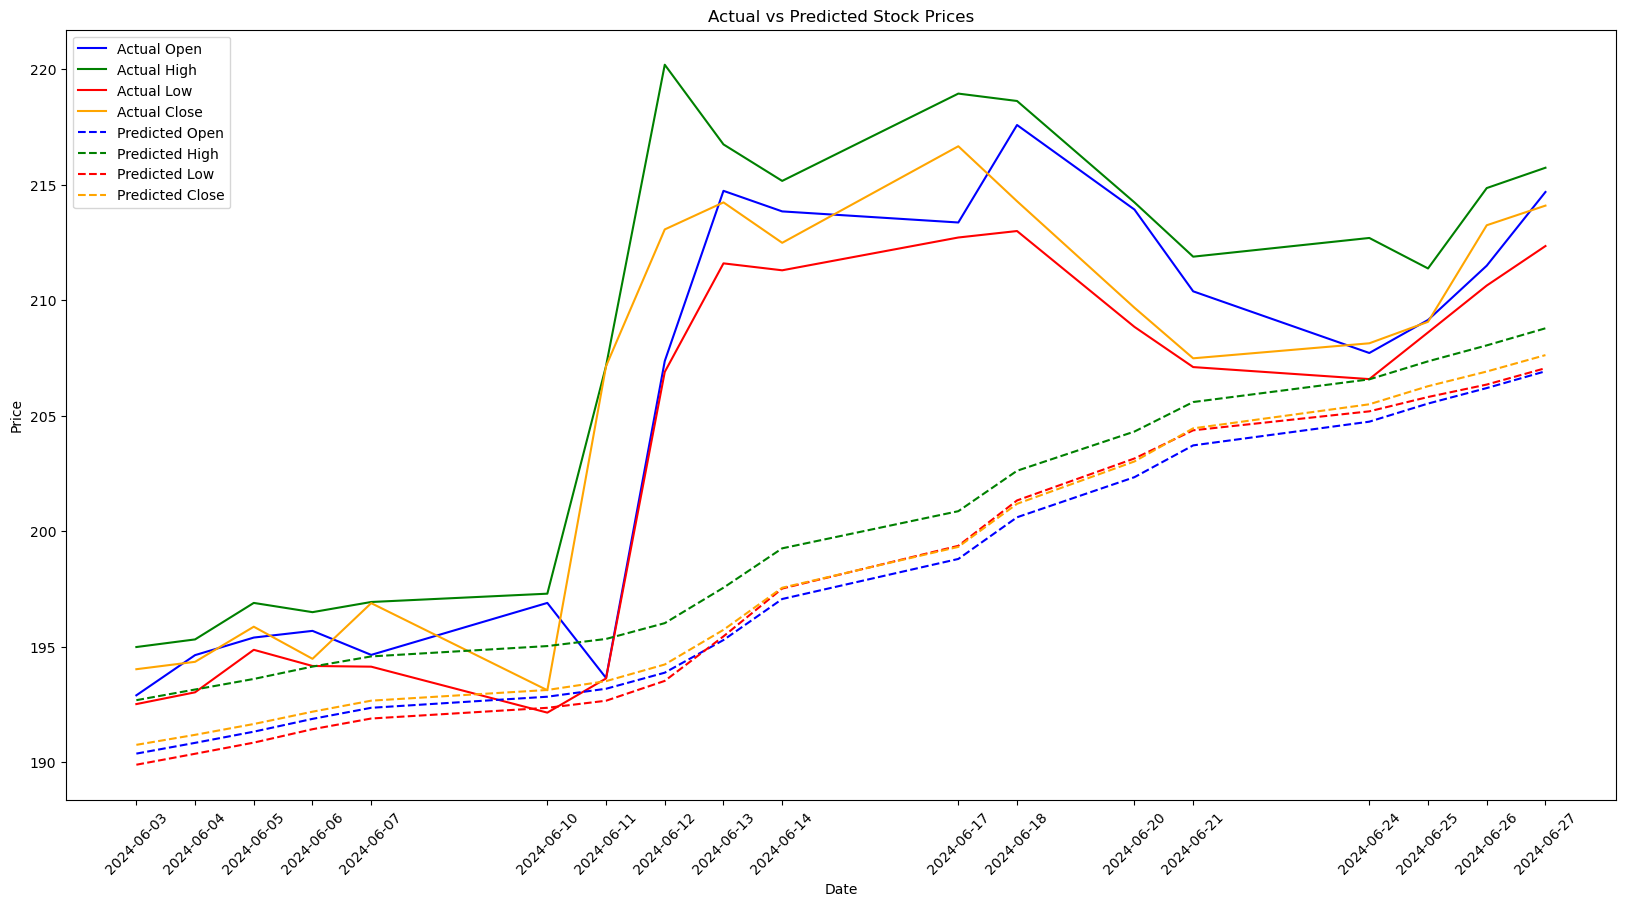

In [36]:
# Plotting
plt.figure(figsize=(20, 10))

plt.plot(filtered_dates, filtered_inv_y_test['Open'], label='Actual Open', color='blue')
plt.plot(filtered_dates, filtered_inv_y_test['High'], label='Actual High', color='green')
plt.plot(filtered_dates, filtered_inv_y_test['Low'], label='Actual Low', color='red')
plt.plot(filtered_dates, filtered_inv_y_test['Close'], label='Actual Close', color='orange')

plt.plot(filtered_dates, filtered_inv_predictions['Open'], label='Predicted Open', linestyle='--', color='blue')
plt.plot(filtered_dates, filtered_inv_predictions['High'], label='Predicted High', linestyle='--', color='green')
plt.plot(filtered_dates, filtered_inv_predictions['Low'], label='Predicted Low', linestyle='--', color='red')
plt.plot(filtered_dates, filtered_inv_predictions['Close'], label='Predicted Close', linestyle='--', color='orange')

plt.legend()
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')

# Adding each date as a tick on the x-axis
plt.xticks(filtered_dates, rotation=45)
plt.show()